# Receptive fields

We will obtain the receptive fields of any given model by building deltas as inputs to calculate the differential response of the model.

## Importing libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import get_file

from perceptnet.networks import PerceptNet
from perceptualtests.receptive_fields import *

## Define a `tf.data.Dataset` from the deltas generator

In [2]:
img_height, img_width, channels, fov = 384, 512, 3, 32

In [3]:
bg_gain = 0.5
delta_gain = 0.05
background = np.zeros(shape=(img_height,img_width,channels)) + bg_gain
deltas_dataset = tf.data.Dataset.from_generator(obtain_receptive_field_gen, 
                                                args=(img_height,img_width,channels,fov, bg_gain, delta_gain),
                                                output_signature=(
                                                    tf.TensorSpec(shape=(img_height,img_width,channels), dtype=tf.float32)
                                                    )
                                                )

2022-06-15 11:27:32.466401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5


## Passing the deltas through the network

In [4]:
weights_path = get_file(fname='perceptnet_rgb.h5',
                        origin='https://github.com/Jorgvt/perceptnet/releases/download/Weights/final_model_rgb.h5')

In [5]:
model = PerceptNet(kernel_initializer='ones', gdn_kernel_size=1, learnable_undersampling=False)
model.build(input_shape=(None, 384, 512, 3))
model.load_weights(weights_path)

In [20]:
def get_all_outputs(model, inputs):
    outputs = [model.layers[0](inputs)]
    for layer in model.layers[1:]:
        output = layer(outputs[-1])
        outputs.append(output)
    return outputs

In [22]:
def get_all_diffs(responses1, responses2):
    return [r1-r2 for r1, r2 in zip(responses1, responses2)]

In [21]:
outputs = get_all_outputs(model, background[None,:,:,:])

### Keeping all the channels

In [26]:
for a in responses_bg:
    print(a.shape)

(1, 384, 512, 3)
(1, 384, 512, 3)
(1, 192, 256, 3)
(1, 192, 256, 3)
(1, 192, 256, 6)
(1, 96, 128, 6)
(1, 96, 128, 6)
(1, 96, 128, 128)
(1, 96, 128, 128)


In [30]:
responses_all = []
for rbg in responses_bg:
    response = np.empty(shape=((fov*2)*(fov*2)*channels, rbg.shape[-1]))
    responses_all.append(response)

In [32]:
%%time
batch_size = 32
output_channels = 128

## We will calculate the responses to the background first
responses_bg = get_all_outputs(model, background[None,:,:,:])
outputs_channels = [rbg.shape[-1] for rbg in responses_bg]
responses_all = []
for rbg in responses_bg:
    response = np.empty(shape=((fov*2)*(fov*2)*channels, rbg.shape[-1]))
    responses_all.append(response)

for i, delta in tqdm(enumerate(deltas_dataset.batch(batch_size)), total=fov*2*fov*2*channels//batch_size):
    responses_batch = get_all_outputs(model, delta)
    responses_batch = get_all_diffs(responses_batch, responses_bg)
    ## Now we keep only the center response of a specific channel
    for response, responses in zip(responses_batch, responses_all):
        response_height, response_width = response.shape[1:3] # [BatchDim, H, W, C]
        responses[i*batch_size:i*batch_size+batch_size] = response[:,response_height//2,response_width//2,:]

  0%|          | 0/384 [00:00<?, ?it/s]

CPU times: user 55.5 s, sys: 26.8 s, total: 1min 22s
Wall time: 1min 20s


In [36]:
responses_all_norm = [normalization_fixed_0(r, expo=0.5) for r in responses_all]

In [24]:
responses.shape, response.shape

((12288, 128), (16, 96, 128, 128))

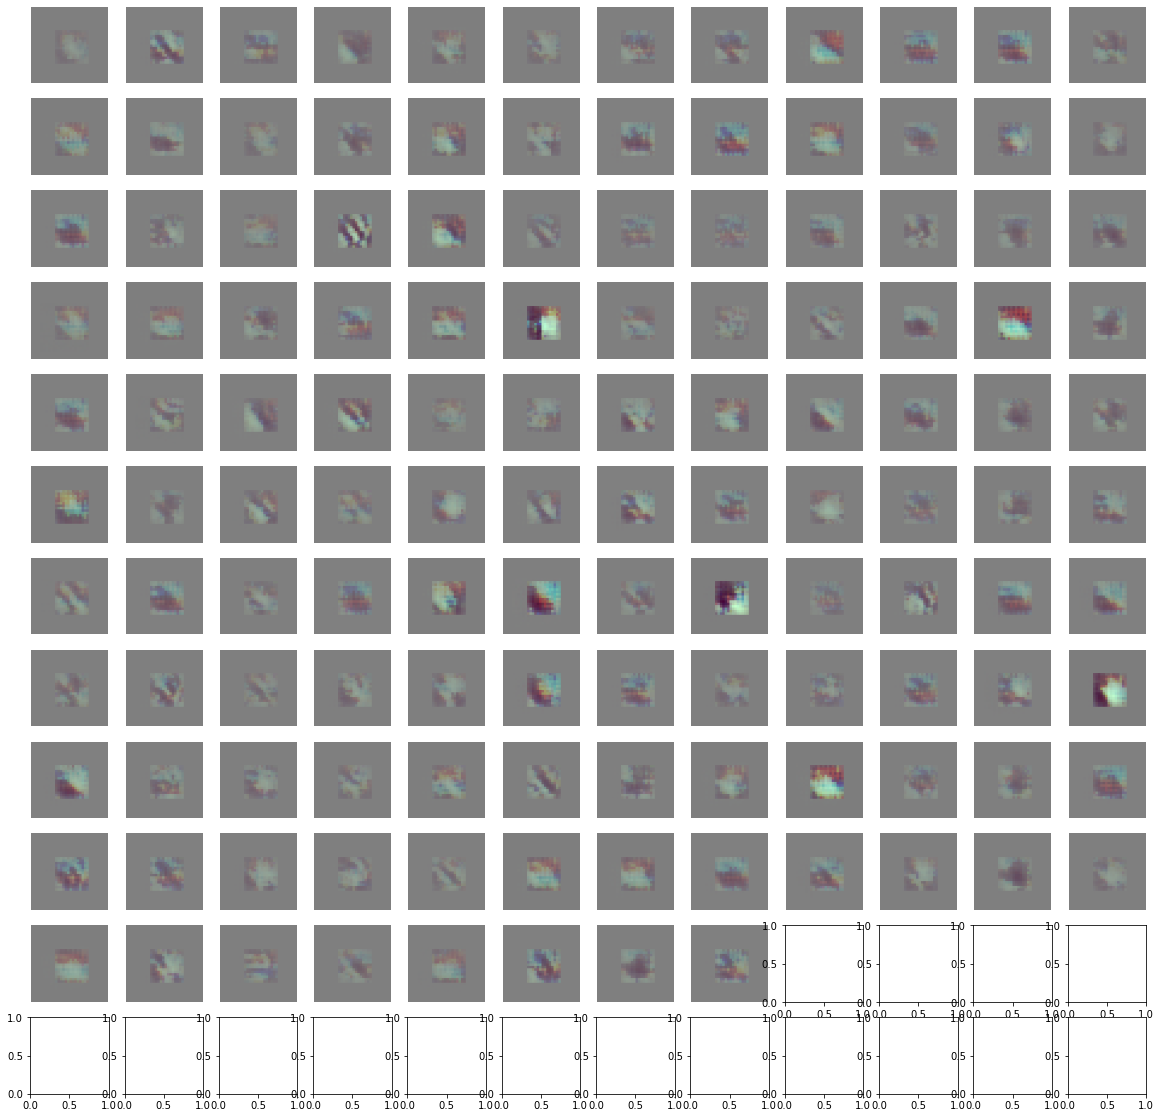

In [25]:
nrows, ncols = [int(np.ceil(np.sqrt(output_channels)))]*2
fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))
ax = ax.ravel()
for ch in range(output_channels):
    ch_response = responses_norm[:,ch]
    ch_response = ch_response.reshape((fov*2, fov*2, channels))
    ax[ch].imshow(ch_response)
    ax[ch].axis('off')
    # break
plt.show()

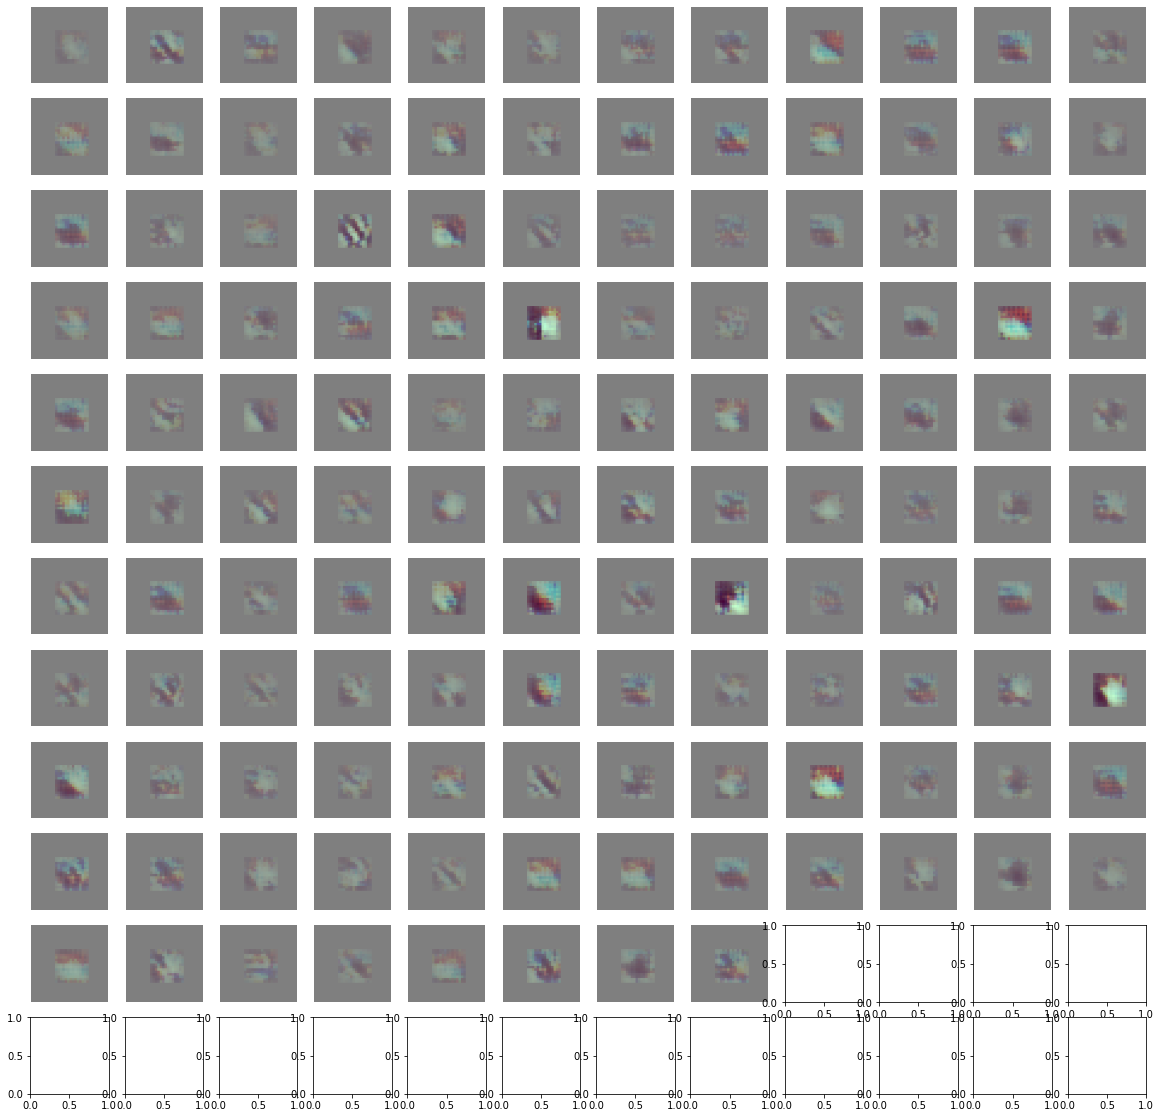

In [35]:
nrows, ncols = [int(np.ceil(np.sqrt(output_channels)))]*2
fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))
ax = ax.ravel()
for ch in range(output_channels):
    ch_response = responses_all_norm[-1][:,ch]
    ch_response = ch_response.reshape((fov*2, fov*2, channels))
    ax[ch].imshow(ch_response)
    ax[ch].axis('off')
    # break
plt.show()

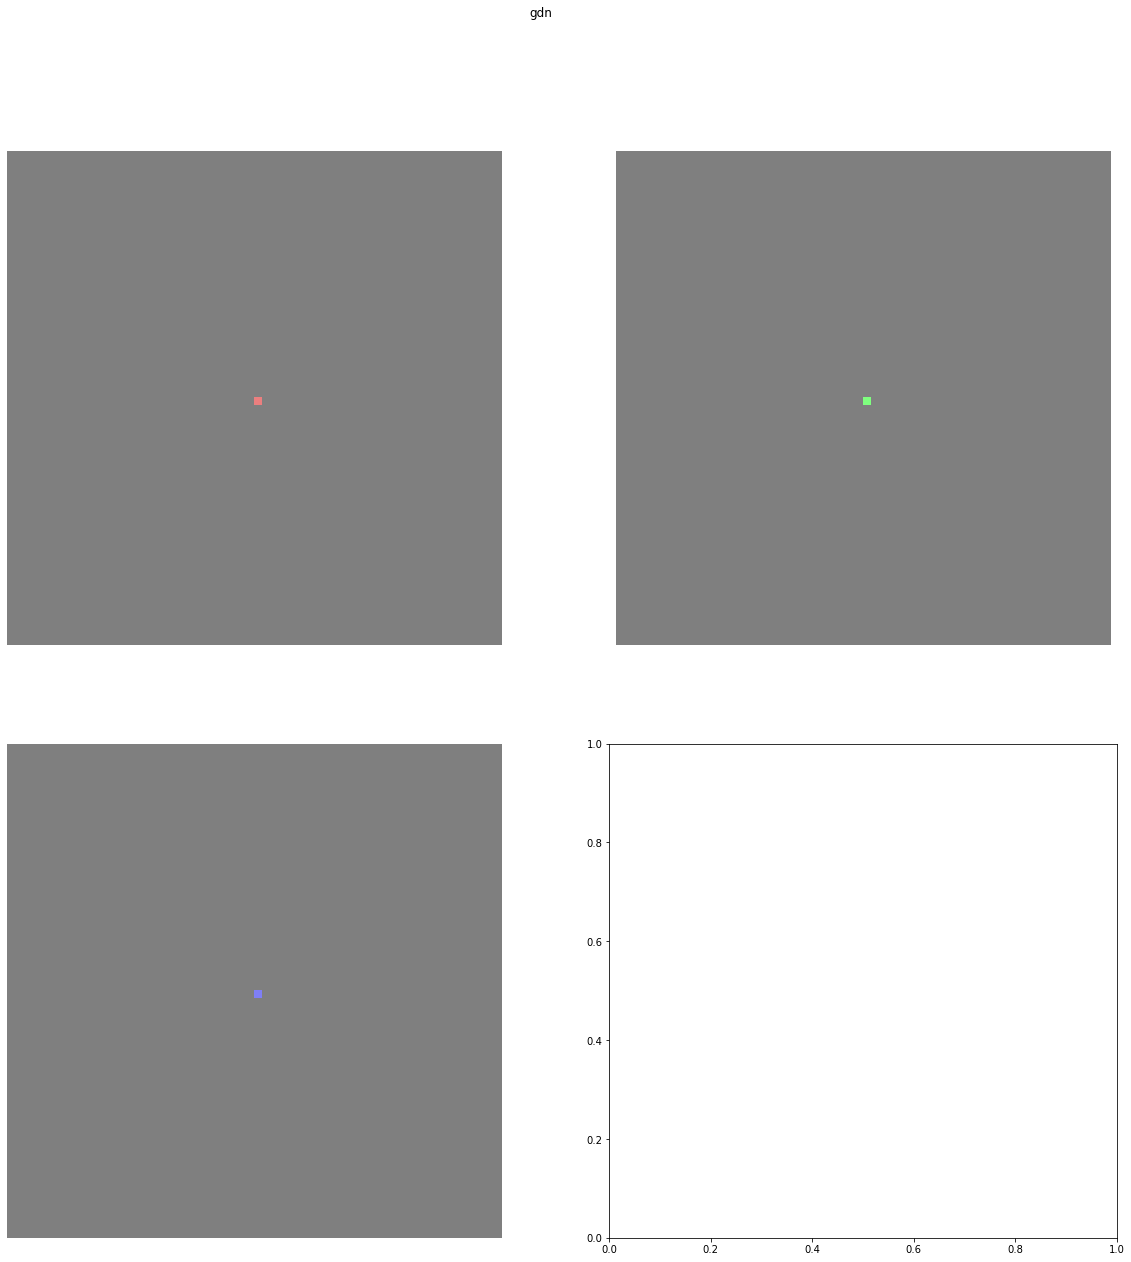

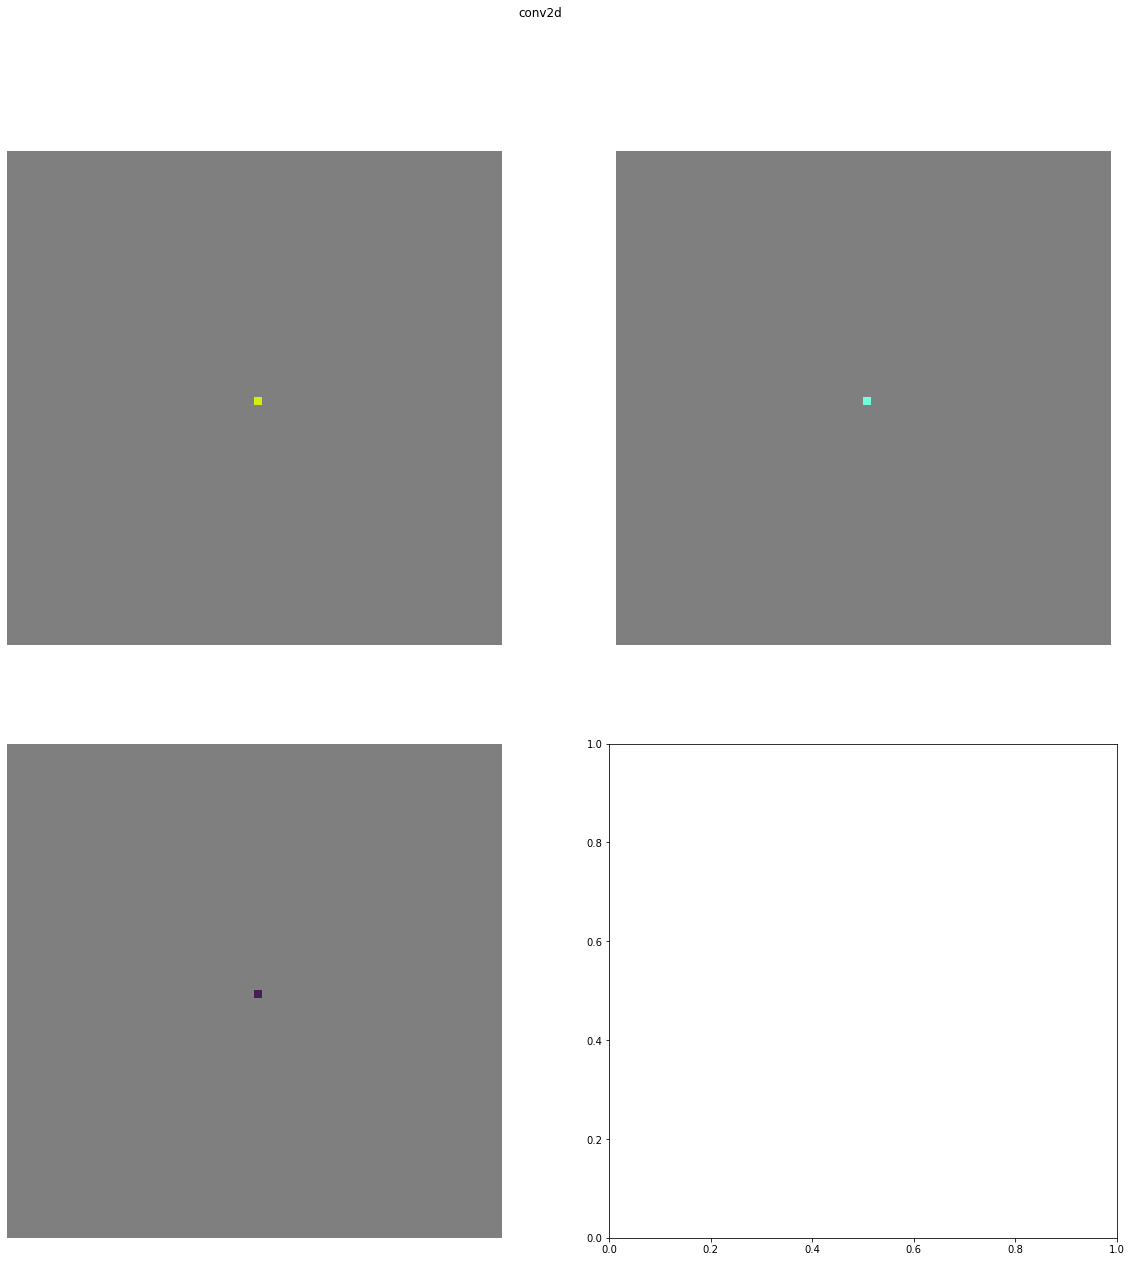

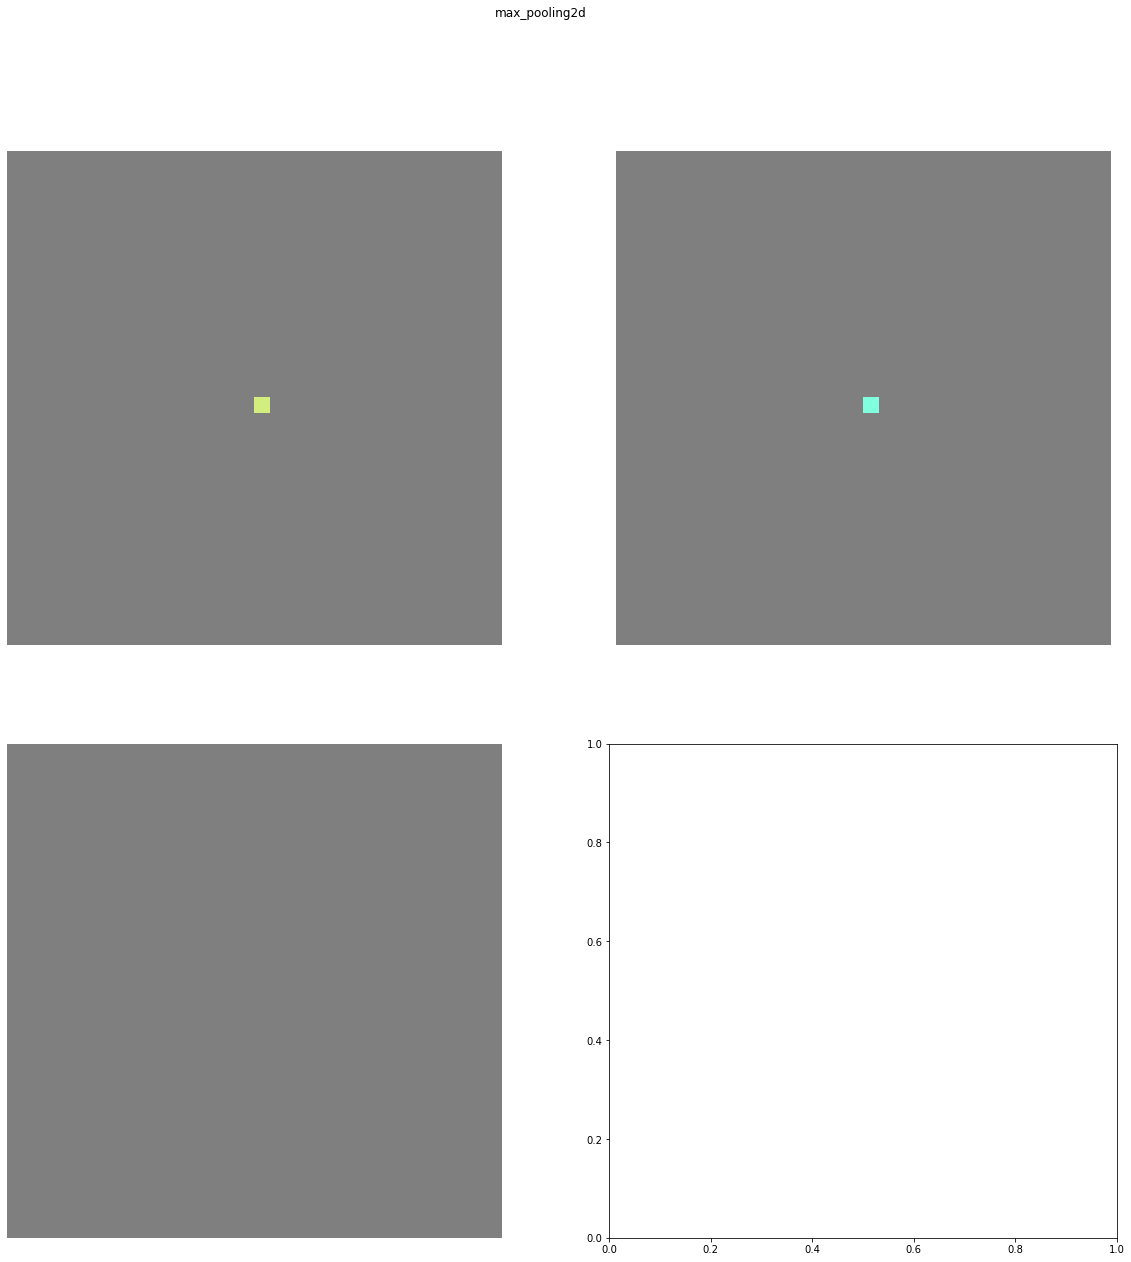

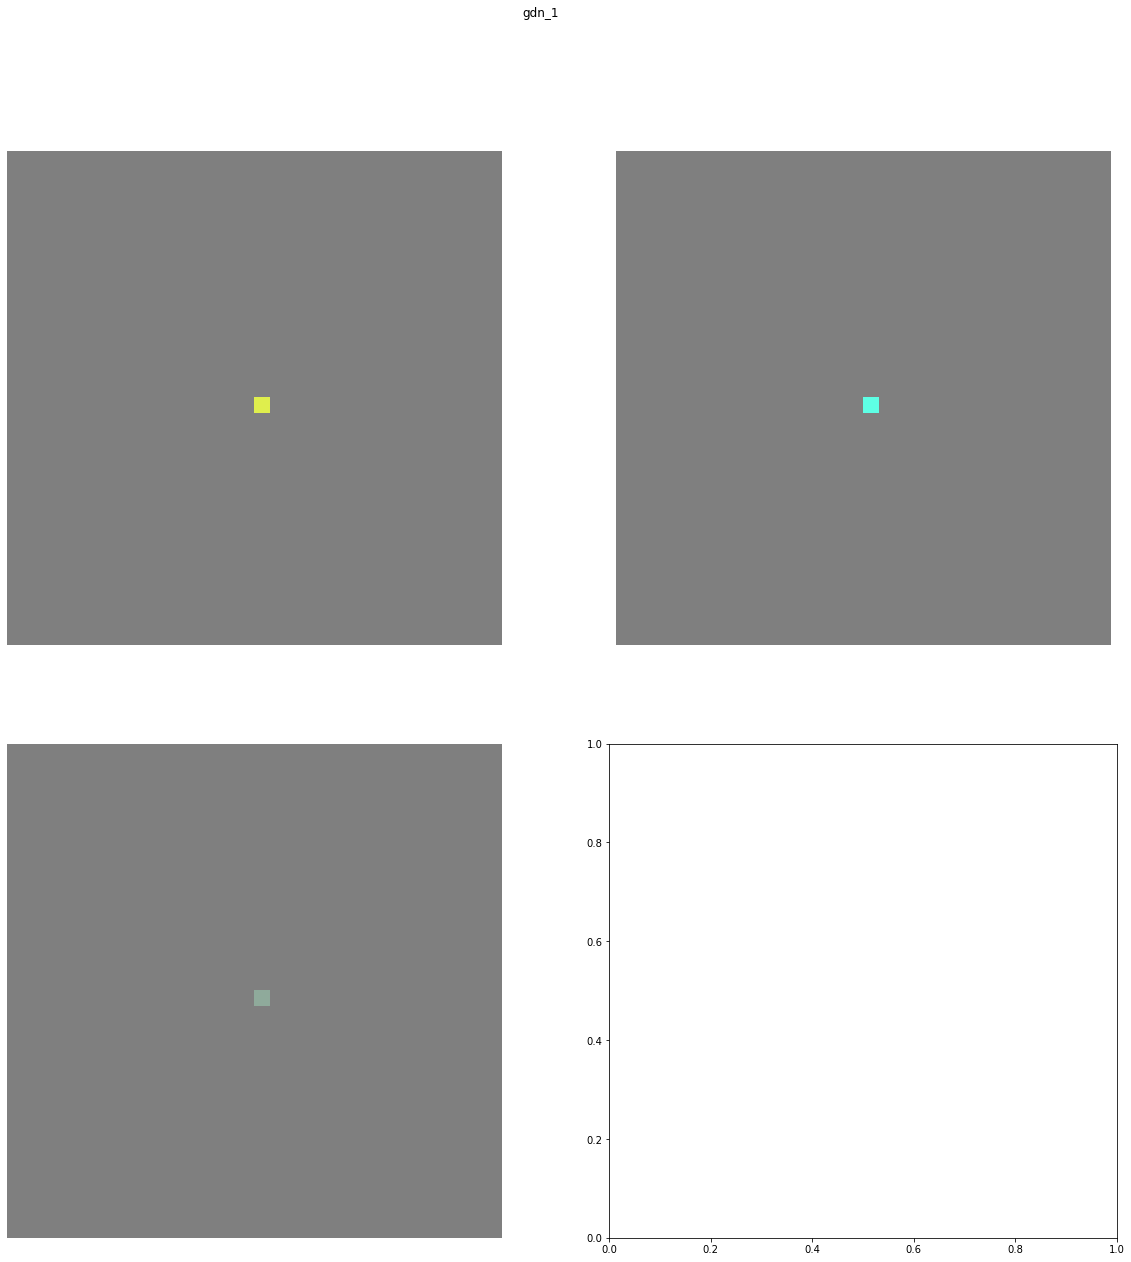

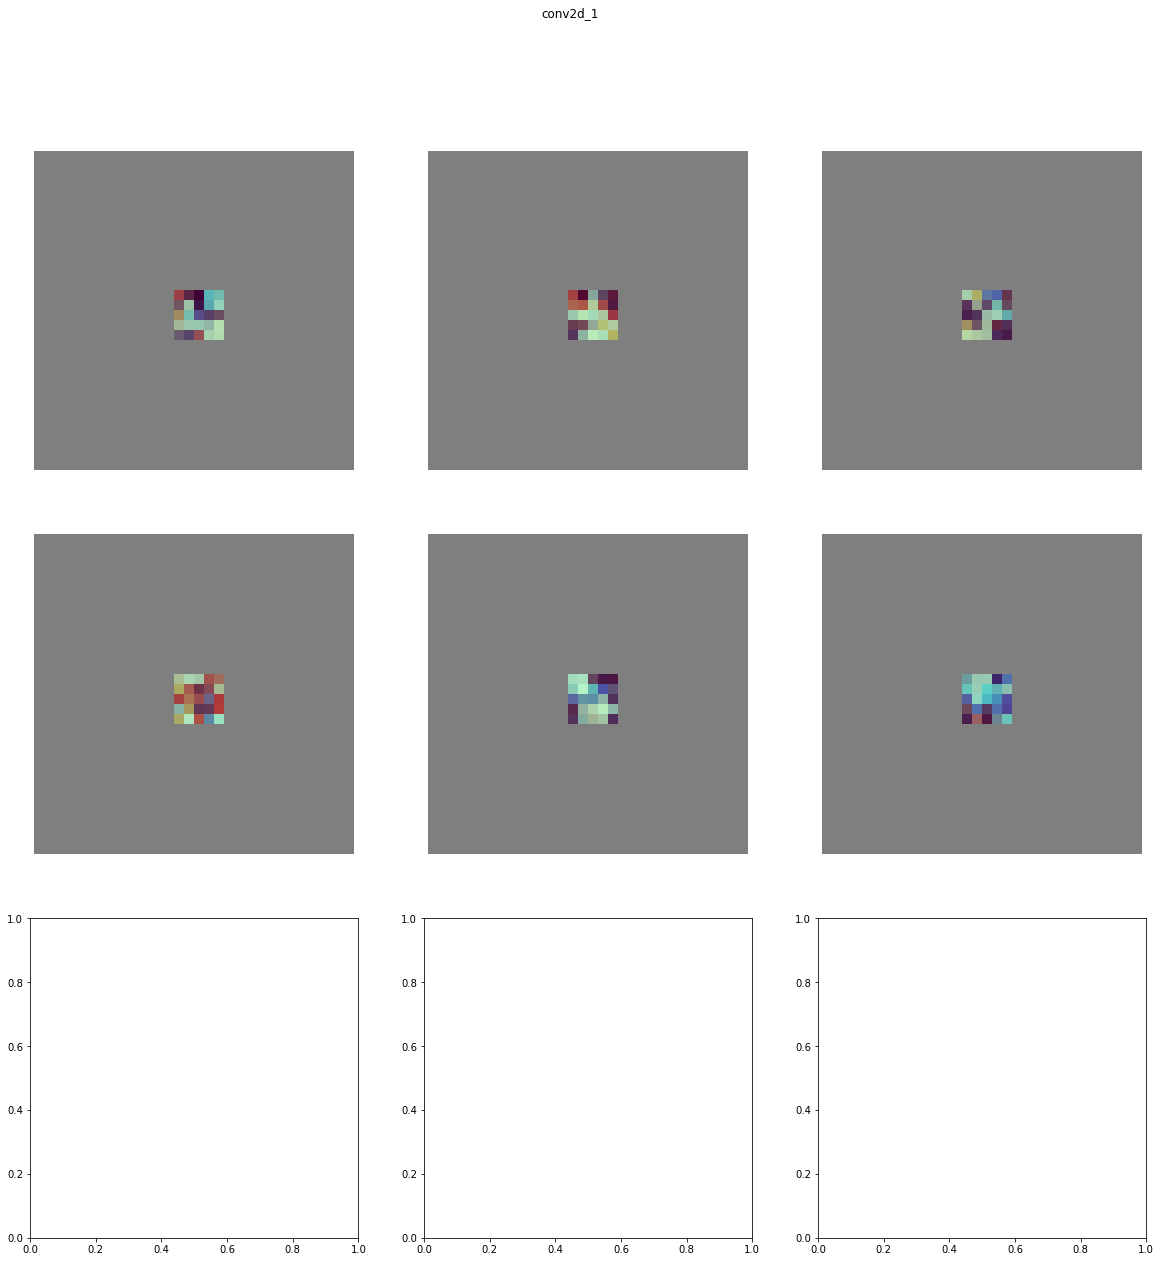

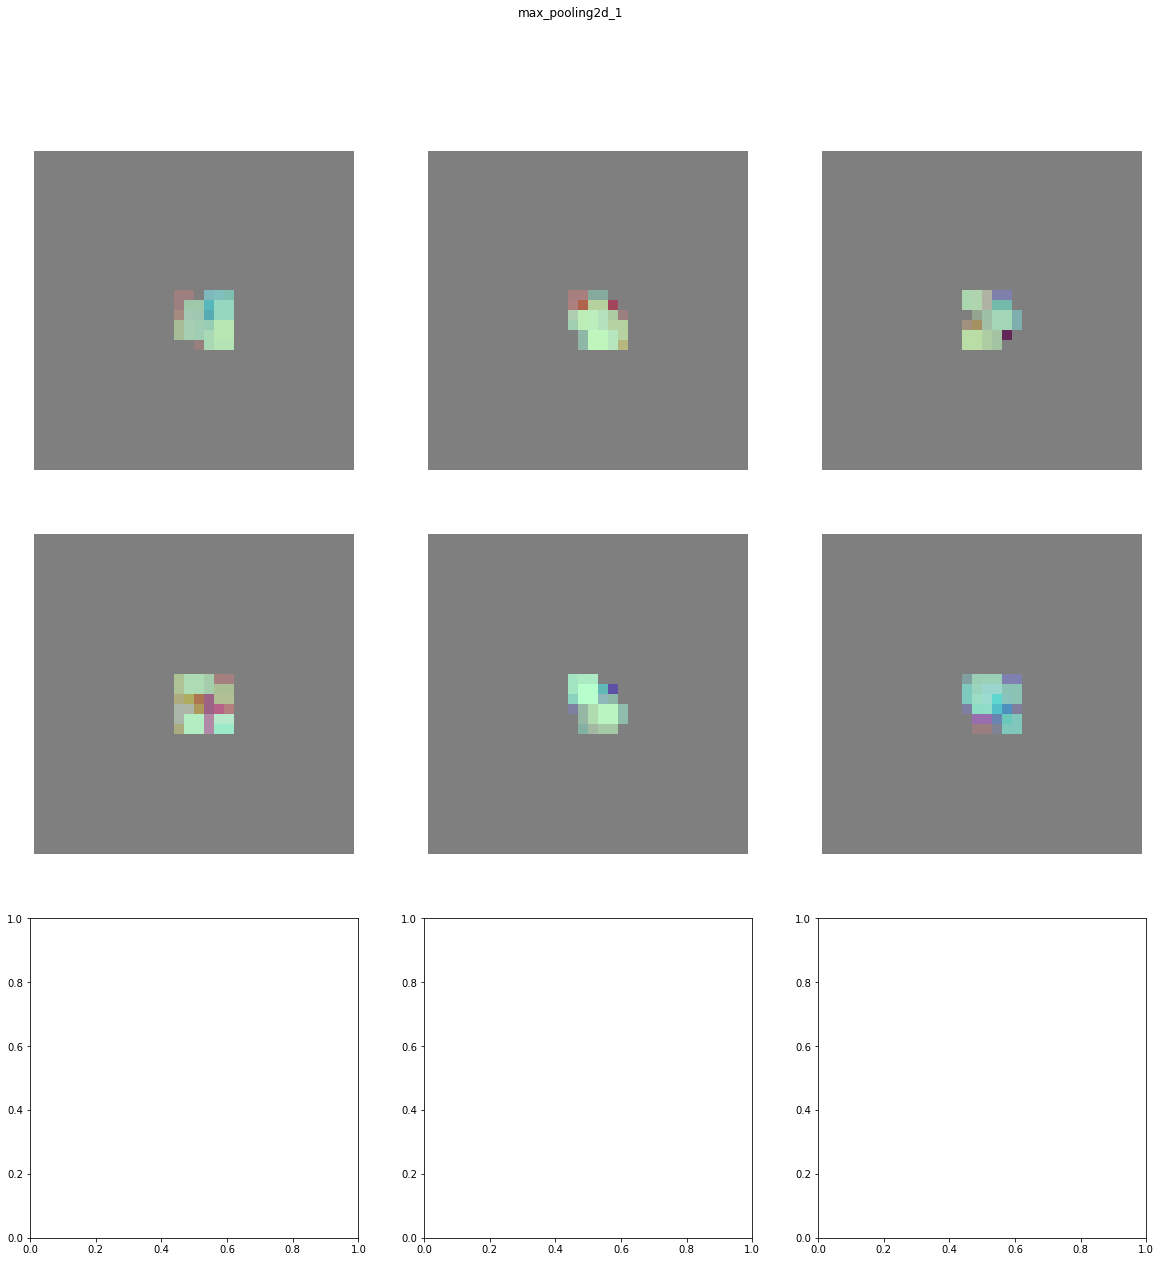

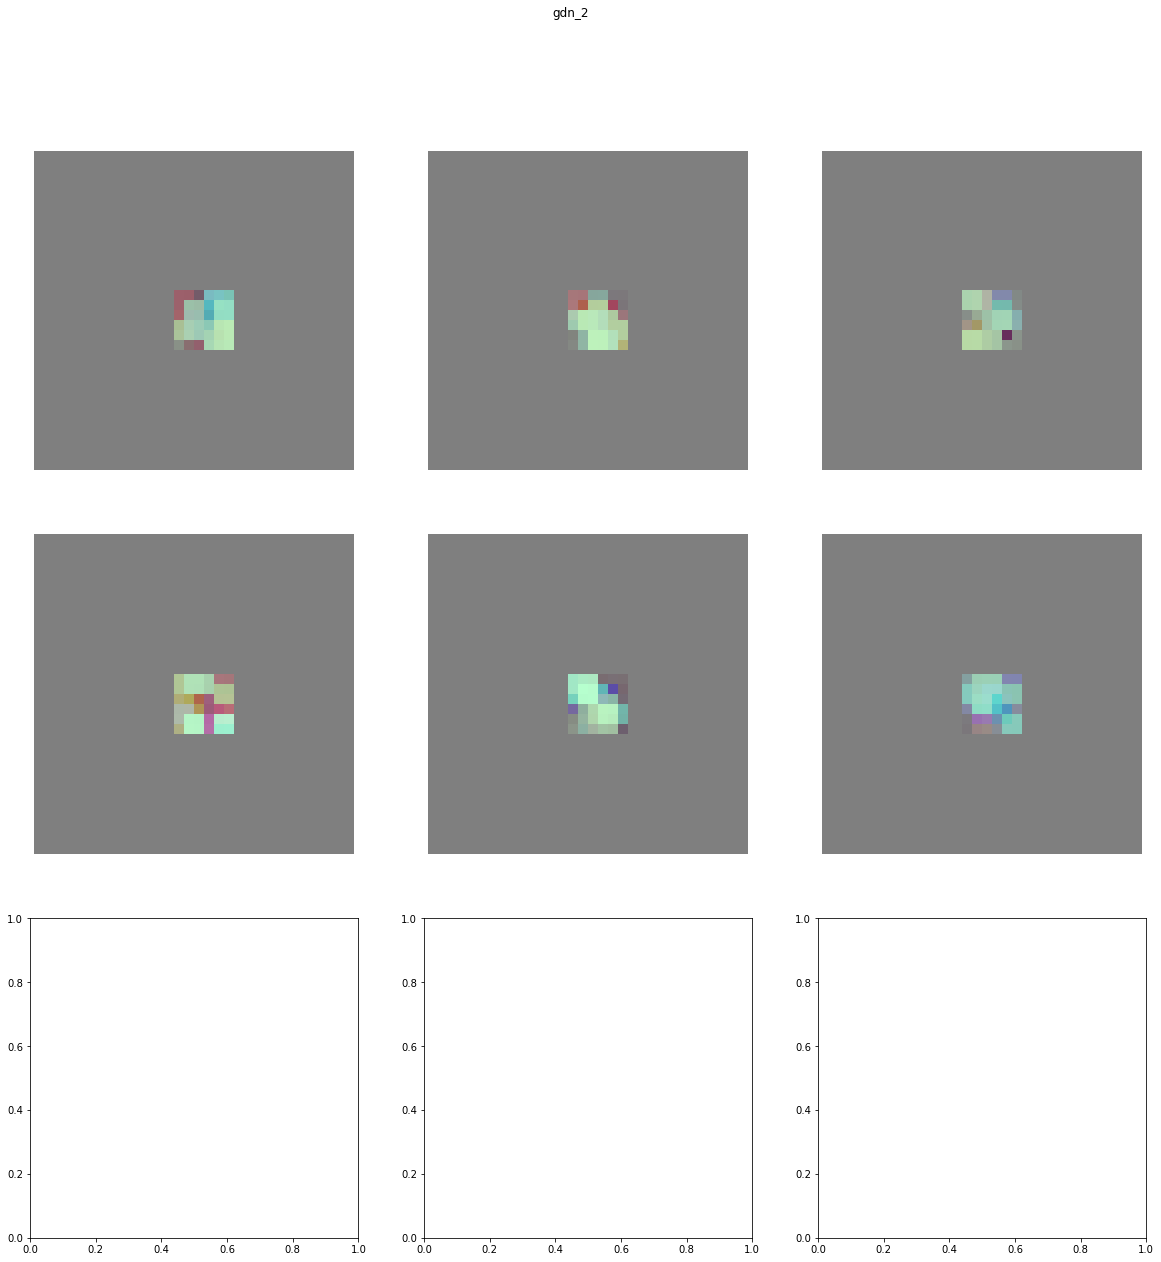

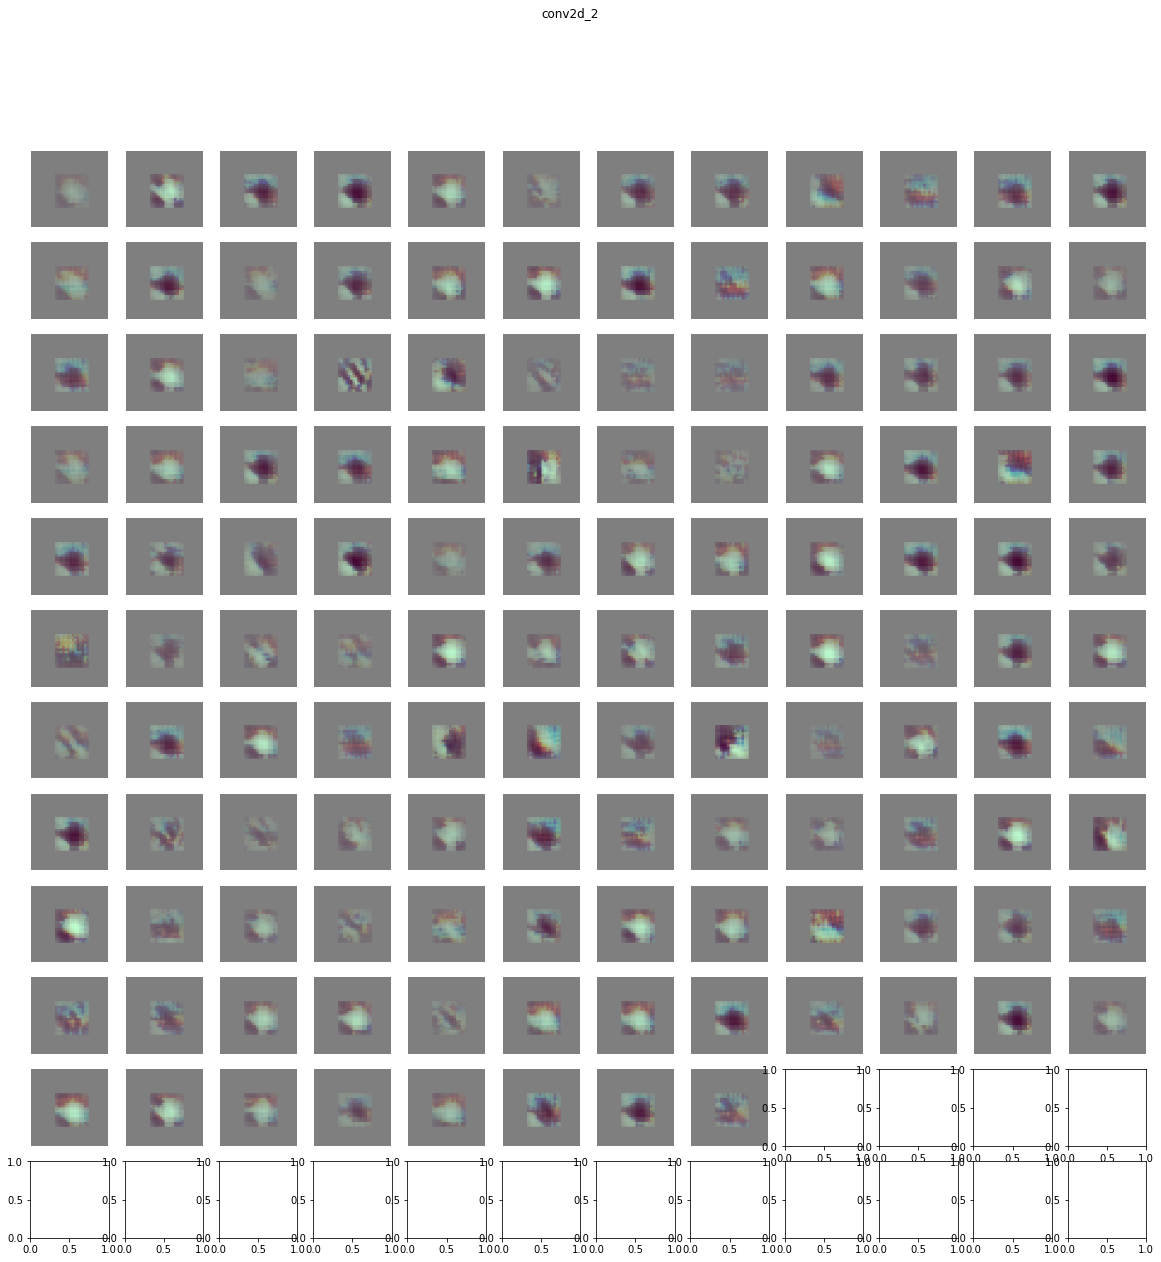

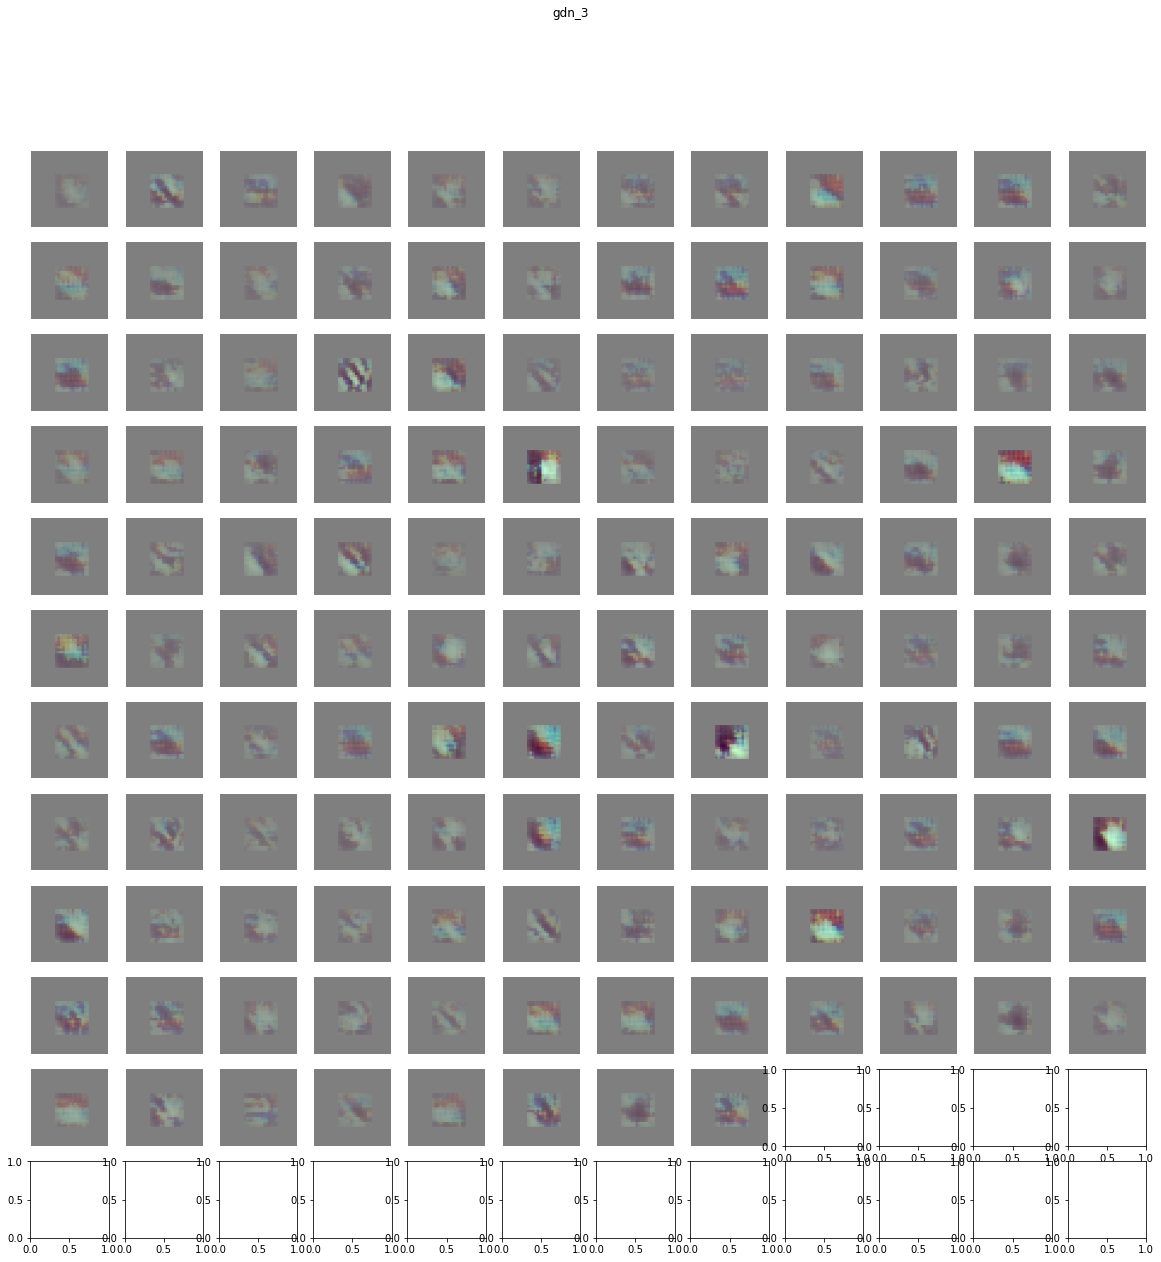

In [41]:
for i, response_norm in enumerate(responses_all_norm):
    nrows, ncols = [int(np.ceil(np.sqrt(outputs_channels[i])))]*2
    fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))
    ax = ax.ravel()
    for ch in range(outputs_channels[i]):
        ch_response = response_norm[:,ch]
        ch_response = ch_response.reshape((fov*2, fov*2, channels))
        ax[ch].imshow(ch_response)
        ax[ch].axis('off')
        # break
    plt.suptitle(model.layers[i].name)
    plt.show()